# Non statistical Analysis of the data

## Importation

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Extraction des données

In [5]:
# Paramètres des données
Stations = ['Aigle', 'Pully', 'Payerne', 'Fretaz', 'Dole', 'Nyon']
stat_index = 1
Format = ['Minutes','Heures']
form_index = 0

# Importation et fusion des années 80-95 et 95-24
file_path1 = '../Database/Precipitations/Data'+Stations[stat_index]+Format[form_index]+'/Data'+Stations[stat_index]+Format[form_index][0]+'8095.txt'
file_path2 = '../Database/Precipitations/Data'+Stations[stat_index]+Format[form_index]+'/Data'+Stations[stat_index]+Format[form_index][0]+'9524.txt'

df = pd.read_csv(file_path1, sep=";", low_memory=False)
df_temp = pd.read_csv(file_path2, sep=";", low_memory=False)

Overlap_num = df['time'].max()
df_temp = df_temp[df_temp['time'] > Overlap_num]
df = pd.concat([df, df_temp], ignore_index=True)

# Epuration des données et temps/value en format adapté
del df_temp
del df['stn']
df = df.replace('-',0.0)
df['time'] = pd.to_datetime(df['time'], format='%Y%m%d%H%M')
df = df[~df['time'].dt.year.isin([1980, 2025])]
df = df.reset_index(drop=True)

value_column = df.columns[1]
df[value_column] = pd.to_numeric(df[value_column], errors='coerce')

# Gestion des moyennes et maximas par an
n = 1

rows_to_keep = len(df) - (len(df) % n)
df = df.iloc[:rows_to_keep]
df['group'] = np.floor(df.index / n)
df['averaged'] = df.groupby('group')[value_column].mean()*6
df['year'] = df['time'].dt.year
pdmaximas = df.groupby('year')['averaged'].max()

# Gestion des données en Numpy

In [6]:
maximas = np.array(pdmaximas)
values = df['averaged'].dropna().to_numpy()
lv = len(values)
time = np.arange(0,lv,1)
time_in_years = time*n/(6*24*366)+1981


# Moyenne mobile

In [7]:
m = 6

moyenne_mob = np.convolve(values,np.ones(m)/m,mode='same')

### Plot moyenne mobile

(1980.0, 2025.0)

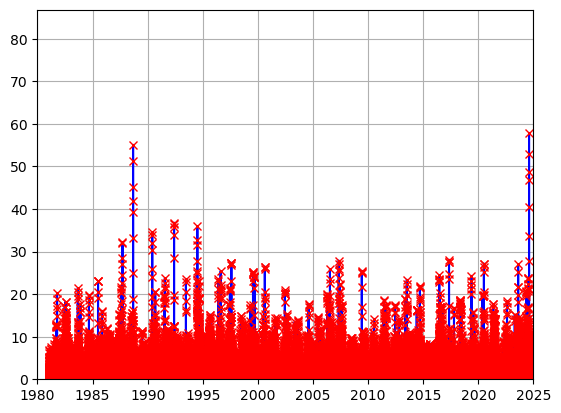

In [8]:
treshold = 0.2

plt.figure()
plt.plot(time_in_years, moyenne_mob,'b-')
plt.plot(time_in_years,treshold*np.ones(len(time_in_years)),'r--')
plt.plot(time_in_years[moyenne_mob>treshold],moyenne_mob[moyenne_mob>treshold],'rx')
plt.grid('on')
plt.ylim(0,1.5*moyenne_mob.max())
plt.xlim(1980,2025)



# Cumulative

In [9]:
def Cumulative(time_serie, damping, inertia_ratio=0):
    cumul = 0
    cumulative = np.zeros(len(time_serie))
    inertia = 0
    for i,t in enumerate(time_serie):
        if t!=0:
            cumul += t*(1-inertia)
            if inertia >= -1 + inertia_ratio:
                inertia -= inertia_ratio
        elif cumul - damping < 0:
            cumul = 0
        else: 
            cumul -= damping*(1+inertia)
            if inertia <= 1 - inertia_ratio:
                inertia += inertia_ratio
        cumulative[i] = cumul
    return cumulative

### Plot cumulative

(1980.0, 2025.0)

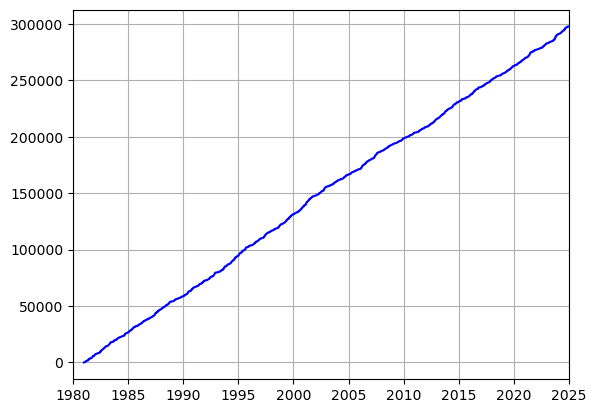

In [12]:
cumulative = Cumulative(values,damping=0.0,inertia_ratio=0.0)

plt.figure()
plt.plot(time_in_years, cumulative, 'b')
plt.grid('on')
plt.xlim(1980,2025)

## Cumulative par année

In [41]:
years = sorted(df['year'].unique())
rain_per_year = [df.loc[df['year'] == y, value_column].values for y in years]
maxlenyear = max(len(r) for r in rain_per_year)
rain_matrix = np.zeros(shape=[len(years), maxlenyear])
Cumulatives = np.zeros(shape=[len(years), maxlenyear])
Cumulative_slopes = np.zeros(shape=[len(years), maxlenyear])
Cumulative_slopes_conv = np.zeros(shape=[len(years), maxlenyear])
slope_interval = 6*24
m = 6*24*7

for i, r in enumerate(rain_per_year):
    rain_matrix[i, :len(r)] = r
    Cumulatives[i, :len(r)] = Cumulative(rain_matrix[i, :len(r)], damping=0.0, inertia_ratio=0.0)
    for j, k in enumerate(Cumulatives[i, :(len(r)-slope_interval)]):
        Cumulative_slopes[i, j] = (Cumulatives[i, j+slope_interval] - Cumulatives[i,j])/slope_interval
    Cumulative_slopes_conv[i] = np.convolve(Cumulative_slopes[i], np.ones(m)/m, mode='same')

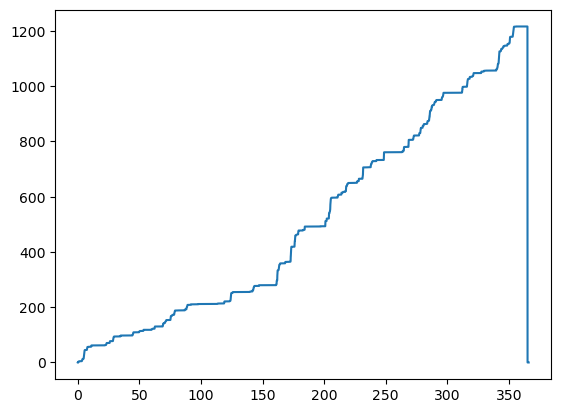

In [42]:
plt.figure()
plt.plot(np.arange(maxlenyear)/(6*24), Cumulatives[1])

<Axes: >

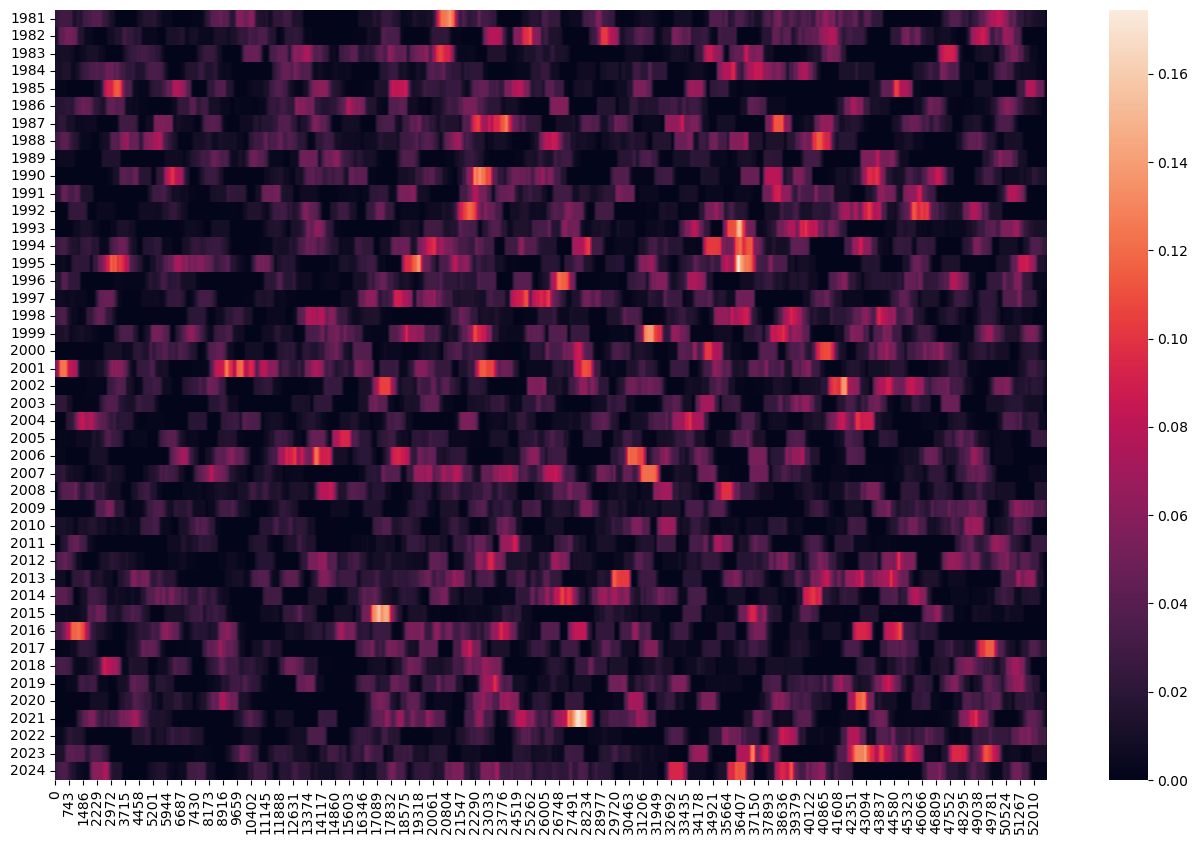

In [43]:
plt.figure(figsize=(16,10))
sns.heatmap(Cumulative_slopes_conv, yticklabels=1981+np.arange(0,len(years)))